## Độ quan trọng của Random Forest

Random forest là một trong các thuật toán học máy phổ biến nhất. Nó rất thành công bởi vì cho chất lượng dự đoán tốt, overfitting thấp và dễ diễn giải. Khả năng diễn giải này là do nó dễ dàng suy ra độ quan trọng của mỗi biến trên DT. Nói cách khác, có thể dễ dàng tính được mức độ đóng góp của mỗi biến cho DT.

Random forest thường  gồm 400-1200 DT, mỗi cây trong số đó được xây dựng dựa trên trích xuất ngẫu nhiên các quan sát từ tập dữ liệu và trích xuất ngẫu nhiên các đặc trưng. Không phải cây nào cũng thấy tất cả các đặc trưng hoặc tất cả các quan sát, điều này đảm bảo rằng các cây giảm tương quan, do đó ít bị overfitting hơn. Mỗi cây cũng là một chuỗi các câu hỏi có-không dựa trên một hoặc tổ hợp các đặc trưng. Ở mỗi nút (tức là ở mỗi câu hỏi), cây chia tập dữ liệu thành 2 bucket, mỗi bucket chứa các quan sát giống nhau hơn và khác với các quan sát trong bucket khác. Do đó, độ quan trọng của mỗi đặc trưng được lấy từ mức độ "thuần túy" của mỗi bucket. 

Chúng ta sẽ dùng phép đo nhiễu là Gini hoặc Entropy cho phân loại. Với hồi quy, phép đo nhiễu là phương sai. Khi huấn luyện cây, có thể tính xem mỗi đặc trưng giảm từng nào nhiễu. Đặc trưng giảm càng nhiều nhiễu thì càng quan trọng. Trong random forest, nhiễu giảm theo từng đặc trưng được tính trung bình trên các cây để xác định độ quan trọng cuối cùng của biến.

Nhìn chung, các đặc trưng được chọn ở đầu cây quan trọng hơn so với các đặc trưng được chọn ở các nút cuối của cây, vì các phân chia ở đầu thu được nhiều thông tin hơn.

**Lưu ý**
- Nhìn chúng, random forest và decision tree ưu tiên các đặc trưng có cardinality cao
- Các đặc trưng tương quan có độ quan trọng bằng nhau hoặc tương tự, nhưng độ quan trọng tổng thể giảm đi so với cùng một cây được xây mà không có đặc trưng tương quan.

Chúng ta sẽ minh họa cách lựa chọn đặc trưng căn cứ theo độ quan trọng của cây trong bài toán phân loại và hồi quy.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

## Phân loại

In [2]:
# load tập dữ liệu
data = pd.read_csv('dataset_2.csv')
data.shape

(50000, 109)

In [3]:
data.head()

,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,...,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109
0,4.532710,3.280834,17.982476,4.404259,2.349910,0.603264,2.784655,0.323146,12.009691,0.139346,...,2.079066,6.748819,2.941445,18.360496,17.726613,7.774031,1.473441,1.973832,0.976806,2.541417
1,5.821374,12.098722,13.309151,4.125599,1.045386,1.832035,1.833494,0.709090,8.652883,0.102757,...,2.479789,7.795290,3.557890,17.383378,15.193423,8.263673,1.878108,0.567939,1.018818,1.416433
2,1.938776,7.952752,0.972671,3.459267,1.935782,0.621463,2.338139,0.344948,9.937850,11.691283,...,1.861487,6.130886,3.401064,15.850471,14.620599,6.849776,1.098210,1.959183,1.575493,1.857893
3,6.020690,9.900544,17.869637,4.366715,1.973693,2.026012,2.853025,0.674847,11.816859,0.011151,...,1.340944,7.240058,2.417235,15.194609,13.553772,7.229971,0.835158,2.234482,0.946170,2.700606
4,3.909506,10.576516,0.934191,3.419572,1.871438,3.340811,1.868282,0.439865,13.585620,1.153366,...,2.738095,6.565509,4.341414,15.893832,11.929787,6.954033,1.853364,0.511027,2.599562,0.811364


**Quan trọng**

Trong tất cả các quy trình lựa chọn đặc trưng, chỉ nên chọn các đặc trưng bằng cách kiểm tra tập huấn luyện, điều này giúp tránh overfit.

In [4]:
# tách thành tập huấn luyện và tập kiểm tra
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['target'], axis=1),
    data['target'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((35000, 108), (15000, 108))

<details><summary> Gợi ý </summary>

[train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

</details>

### Lựa chọn đặc trưng với độ quan trọng của cây

In [5]:
# chúng ta khớp Random Forest và lựa chọn đặc trưng trong 2 dòng code

# đầu tiên, chỉ định thực thể Random Forest và các tham số

# Sau đó, sử dụng lớp SelectFromModel từ sklearn
# để tự động lựa chọn đặc trưng

# SelectFromModel sẽ chọn các đặc trưng có độ quan trọng 
# lớn hơn độ quan trọng trung bình của tất cả các đặc trưng 
# theo mặc định, nhưng chúng ta có thể thay đổi ngưỡng này nếu muốn
## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:
sel_ = SelectFromModel(RandomForestClassifier(n_estimators=10, random_state=10))

sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10,
                                                 random_state=10))

<details><summary> Gợi ý </summary>

[SelectFromModel()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

</details>

In [6]:
# dòng lệnh này, hãy hiển thị các đặc trưng đã chọn

# sklearn sẽ lựa chọn các đặc trưng có giá trị độ quan trọng
# lớn hơn trung bình tất cả các hệ số.
## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:
sel_.get_support()

array([ True,  True, False, False, False,  True, False, False,  True,
       False, False, False,  True, False,  True,  True,  True, False,
       False,  True,  True, False, False, False, False, False, False,
       False, False,  True, False, False, False,  True, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False,  True, False, False, False,
       False, False,  True, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False,  True,  True, False, False,  True, False,
       False, False,  True, False, False, False, False,  True, False])

<details><summary> Gợi ý </summary>

Sử dụng ```get_support()```

</details>

In [7]:
# tạo một danh sách và đếm các đặc trưng đã chọn

## Yêu cầu 4:
## VIẾT CODE Ở ĐÂY:
selected_feat = X_train.columns[(sel_.get_support())]

len(selected_feat)

27

<details><summary> Gợi ý </summary>

Sử dụng ```get_support()```

</details>

In [8]:
selected_feat

Index(['var_1', 'var_2', 'var_6', 'var_9', 'var_13', 'var_15', 'var_16',
       'var_17', 'var_20', 'var_21', 'var_30', 'var_34', 'var_37', 'var_55',
       'var_60', 'var_67', 'var_69', 'var_70', 'var_71', 'var_82', 'var_87',
       'var_88', 'var_95', 'var_96', 'var_99', 'var_103', 'var_108'],
      dtype='object')

### Vẽ biểu đồ thể hiện độ quan trọng

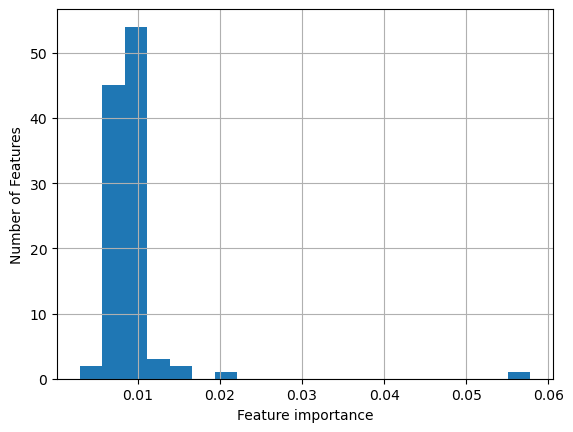

In [9]:
# giờ hãy vẽ biểu đồ phân phối của độ quan trọng
## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:
pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
plt.xlabel('Feature importance')
plt.ylabel('Number of Features')
plt.show()

<details><summary> Gợi ý </summary>

Sử dụng ```feature_importances_```

</details>

In [10]:
# hãy so sánh lượng các đặc trưng đã chọn
# với lượng đặc trưng có độ quan trọng lớn hơn
# trung bình tất cả các đặc trưng, để đảm bảo chúng ta hiểu đầu ra của
# SelectFromModel

print('total features: {}'.format((X_train.shape[1])))

print('selected features: {}'.format(len(selected_feat)))
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:
print(
    'features with importance greater than the mean importance of all features: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 108
selected features: 27
features with importance greater than the mean importance of all features: 27


<details><summary> Gợi ý </summary>

Sử dụng ```feature_importances_```

</details>

Một số điều cần lưu ý:

- Nếu thay đổi tham số của cây, chúng ta sẽ thu được các đặc trưng khác nhau
- Số lượng đặc trưng để chọn là tùy ý

Chúng ta có thể sử dụng giá trị trung bình tất cả các đặc trưng làm ngưỡng với SelectFromModel. Ngưỡng này có thể chỉnh sửa trong SelectFromModel nếu chúng ta muốn tăng hoặc giảm đặc trưng.

## Mở rộng với bài toán Hồi quy

In [11]:
# load tập dữ liệu
data = pd.read_csv('houseprice.csv')
data.shape

(1460, 81)

In [12]:
# Thực tế, nên lựa chọn đặc trưng sau khi tiền xử lý dữ liệu,
# do đó, tất cả các biến hạng mục được mã hóa thành số,
# sau đó chúng ta có thể đánh giá tính tất định của mục tiêu

# để đơn giản, chúng ta sẽ chỉ sử dụng biến dạng số
# lựa chọn các cột số:

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]
data.shape

(1460, 38)

<details><summary> Gợi ý </summary>

Sử dụng ```numerics``` và ```numerical_vars```

</details>

In [13]:
# tách thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 37), (438, 37))

In [14]:
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

### Lựa chọn đặc trưng với độ quan trọng của cây

In [15]:
# chúng ta huấn luyện random forest cho hồi quy và lựa chọn đặc trưng
# trong 2 dòng code

# SelectFromModel sẽ chọn các đặc trưng có độ quan trọng
# lớn hơn độ quan trọng trung bình của tất cả các đặc trưng
# theo mặc định, nhưng chúng ta có thể thay đổi ngưỡng này nếu muốn
## Yêu cầu 8:
## VIẾT CODE Ở ĐÂY:
sel_ = SelectFromModel(RandomForestRegressor(n_estimators=100, random_state=10))
sel_.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(random_state=10))

<details><summary> Gợi ý </summary>

[SelectFromModel()](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

</details>

In [16]:
# tạo một danh sách và đếm các đặc trưng đã chọn
selected_feat = X_train.columns[(sel_.get_support())]
len(selected_feat)

5

In [17]:
# hãy so sánh lượng các đặc trưng đã chọn
# với lượng đặc trưng có độ quan trọng lớn hơn
# độ quan trọng trung bình, để đảm bảo chúng ta hiểu được đầu ra của
# sklearn

print('total features: {}'.format((X_train.shape[1])))
## Yêu cầu 9:
## VIẾT CODE Ở ĐÂY:
print('selected features: {}'.format(len(selected_feat)))

print(
    'features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(sel_.estimator_.feature_importances_ >
               sel_.estimator_.feature_importances_.mean())))

total features: 37
selected features: 5
features with coefficients greater than the mean coefficient: 5


<details><summary> Gợi ý </summary>

Sử dụng ```selected_feat```

</details>

Lựa chọn đặc trưng bằng cách sử dụng độ quan trọng của đặc trưng bắt nguồn từ cây nói chung là một cách đơn giản, nhanh chóng và chính xác để lựa chọn đặc trưng tốt cho học máy. Đặc biệt là nếu bạn định xây dựng phương pháp cây.

Tuy nhiên, như tôi đã nói, các đặc trưng tương quan sẽ hiển thị độ quan trọng tương tự, nhưng thấp hơn so với độ quan trọng của cây được xây  mà không có các đặc trưng tương quan.

Trong những tình huống như vậy, tốt hơn là chọn các đặc trưng một cách đệ quy thay vì lựa chọn đầy đủ như chúng ta thực hiện trong bài giảng này. 
